In [6]:
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt


# import my modules (helpers.py where I stored all the functions):
import helpers as hlp
import importlib 
importlib.reload(hlp)
from clarity.evaluator.hasqi import hasqi_v2
from clarity.evaluator.haspi import haspi_v2 
from clarity.evaluator.mbstoi import mbstoi 
import torch
import sys
from multiprocessing import Pool


In [ ]:
# All our directories in which we store recordings or dnn-processed recordings:
data_source_dirs=[
    '/home/ubuntu/Data/ha_listening_situations/recordings/ku_recordings/',
    '/home/ubuntu/Data/ha_listening_situations/processed_m1_alldata_normal/ku_processed/',
    '/home/ubuntu/Data/ha_listening_situations/processed_m3_alldata_mild/ku_processed/',
    '/home/ubuntu/Data/ha_listening_situations/processed_m4_alldata_normal_causal/ku_processed/',
    '/home/ubuntu/Data/ha_listening_situations/processed_m5_alldata_mild_causal/ku_processed/'
]

# Different listening scenes:
scenenames=['party_0deg','party_30deg','restaurant_0deg','restaurant_30deg','meeting_0deg','meeting_30deg']

# Initialize dataframe, in which each row will represent one pair of plus and minus recording
# and all the info and objective measures associated with that pair. 
measures=pd.DataFrame(columns=['device','dnn_applied','plus_file','minus_file', 'scene'])

dnntypes=[]
pluses=[]
minuses=[]
scenes=[]
devices=[]
for i, data_source_dir in enumerate(data_source_dirs):
    for item in sorted(os.listdir(data_source_dir)):
        if os.path.isdir(data_source_dir+item):
            recording_name=item
            for scene in scenenames:
                plusfilepath=data_source_dir+recording_name+'/'+recording_name+'_plus_'+scene+'.wav'
                minusfilepath=data_source_dir+recording_name+'/'+recording_name+'_minus_'+scene+'.wav'
                applieddnntype=i
                devices.append(recording_name)
                pluses.append(plusfilepath)
                minuses.append(minusfilepath)
                scenes.append(scene)
                dnntypes.append(applieddnntype)

measures['device']=devices            
measures['dnn_applied']=dnntypes
measures['plus_file']=pluses
measures['minus_file']=minuses
measures['scene']=scenes

# Remove the lines where the "enabled" recording is processed and lines where ku100 recording is processed 
# (we are only interested in dnn-processed bypass recordings):
print(f'before: {len(measures)=}')
measures=measures[~((measures["device"].str.contains("enabled")) & (measures["dnn_applied"]>0))]
measures=measures[~((measures["device"].str.contains("001_ku100")) & (measures["dnn_applied"]>0))]
print(f'after: {len(measures)=}')



In [ ]:
def SISDR(s, s_hat):
    """Computes the Scale-Invariant SDR as in [1]_.
    References
    ----------
    .. [1] Le Roux, Jonathan, et al. "SDR–half-baked or well done?." ICASSP 2019-2019 IEEE International Conference on
    Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2019.
    Parameters:
        s: list of targets of any shape
        s_hat: list of corresponding estimates of any shape
    """
    s = torch.stack(s).view(-1)
    EPS = torch.finfo(s.dtype).eps
    s_hat = torch.stack(s_hat).view(-1)
    a = (torch.dot(s_hat, s) * s) / ((s ** 2).sum() + EPS)
    b = a - s_hat
    return -10*torch.log10(((a*a).sum()) / ((b*b).sum()+EPS))

def compute_obj_measures(idx, row):
    # Function: Compute objective measures based on one row of a data frame 
    # ----- Input: -----
    # idx - index in the original data frame
    # row - row containing filenames of plus and minus recording
    # ----- Output: -----
    # tuple of objective measures: 
    # - snr_val: snr estimated with phase inversion technique
    # - mbstoi_val: binaural speech intelligibility model
    # - hasqi_left_val: hearing aid speech quality for 1 ear
    # - hasqi_left_val: hearing aid speech perception index for 1 ear
    # - sisdr_val: sudo-rm-rf method for computing sdr
    # ----------------------------------------------------------------------
    fs, plus = wavfile.read(row['plus_file'])
    fs, minus = wavfile.read(row['minus_file'])
    plus=plus.astype(np.float32) # resample_poly() cannot take ints!
    minus=minus.astype(np.float32)
    # ------------- Objective measure 1: SNR -------------
    s=0.5*(plus+minus)
    n=0.5*(plus-minus)
    snr_left_val = 10 * np.log10(hlp.power(s[:,0]) / hlp.power(n[:,0]))
    snr_right_val = 10 * np.log10(hlp.power(s[:,1]) / hlp.power(n[:,1]))
    snr_val =10 * np.log10(hlp.power(s) / hlp.power(n))
    # ------------- Objective measure 2: MBSTOI -------------
    mbstoi_val = mbstoi(
        left_ear_clean=s[:,0],
        right_ear_clean=s[:,1],
        left_ear_noisy=plus[:,0],
        right_ear_noisy=plus[:,1],
        fs_signal=fs,  # signal sample rate
        sample_rate=9000,  # operating sample rate
        fft_size_in_samples=64,
        n_third_octave_bands=5,
        centre_freq_first_third_octave_hz=500,
        dyn_range=60,
    )
    # ------------- Objective measure 3 & 4: HASQI and HASPI -------------
    hearing_loss = np.array([0, 0, 0, 0, 0, 0])
    equalisation_mode=1
    level1=65
    hasqi_left_val, _, _, _ = hasqi_v2(s[:,0], fs, plus[:,0], fs, hearing_loss, equalisation_mode, level1)
    haspi_left_val, _ = haspi_v2(s[:,0], fs, plus[:,0] + s[:,0], fs, hearing_loss, level1)

    # ------------- Objective measure 5: SI-SDR -------------
    sisdr_val=SISDR([torch.from_numpy(s)],[torch.from_numpy(plus)]).item()

    return idx, snr_left_val,snr_right_val,snr_val, mbstoi_val, hasqi_left_val, haspi_left_val,sisdr_val

# The main script has to be in the same cell as the definition of the function
if __name__ == '__main__':
    NUM_OF_WORKERS = 8
    with Pool(NUM_OF_WORKERS) as pool:
        results = [pool.apply_async(compute_obj_measures, [idx, row]) for idx, row in measures.iterrows()]
        for result in results:
            idx, snr_left, snr_right, snr, mbstoi, hasqi_left, haspi_left, sisdr = result.get()
            measures.loc[idx, 'snr_left'] = snr_left
            measures.loc[idx, 'snr_right'] = snr_right
            measures.loc[idx, 'snr'] = snr
            measures.loc[idx, 'mbstoi'] = mbstoi
            measures.loc[idx, 'hasqi_left'] = hasqi_left
            measures.loc[idx, 'haspi_left'] = haspi_left
            measures.loc[idx, 'sisdr'] = sisdr

    measures.to_csv('objective_measures.csv')

In [8]:
# Some important edits before plotting: 

# read dataframe 
measures_computed=pd.read_csv('objective_measures.csv')

# Make sure to remove the lines where the "enabled" recording is processed and lines where ku100 recording is processed 
# (we are only interested in dnn-processed bypass recordings):
print(f'before: {len(measures_computed)=}')
measures_computed=measures_computed[~((measures_computed["device"].str.contains("enabled")) & (measures_computed["dnn_applied"]>0))]
measures_computed=measures_computed[~((measures_computed["device"].str.contains("001_ku100")) & (measures_computed["dnn_applied"]>0))]
print(f'after: {len(measures_computed)=}')

# Within the group that is not processed by any dnn model we have to distinguish 3 categories and give them labels: 
# ---> unprocessed reference: ku100 recordings without a hearing aid
measures_computed.loc[measures_computed["device"].str.contains("001_ku100"), "dnn_applied"]=0.1
# ---> unprocessed bypass: recordings with hearing aids in bypass
measures_computed.loc[((measures_computed["device"].str.contains("bypass")) & (measures_computed["dnn_applied"]==0)), "dnn_applied"]=0.2
# ---> unprocessed enabled: recordings with hearing aids enabled
measures_computed.loc[((measures_computed["device"].str.contains("enabled")) & (measures_computed["dnn_applied"]==0)), "dnn_applied"]=0.3
measures_computed.loc[((measures_computed["device"].str.contains("extra")) & (measures_computed["dnn_applied"]==0)), "dnn_applied"]=0.3

# There is one file name we have to correct:
measures_computed['device']=measures_computed['device'].str.replace('17', '017', regex=True)

# For a better visibility, we add one column which specifies the hearing aid model (without division into different receivers)
ha_models=["gn3","gn5","ph5","ph4","si3","fulldenoising","001_ku"]
for modelname in ha_models:
    measures_computed.loc[measures_computed['device'].str.contains(modelname), "device_group"]=modelname


before: len(measures_computed)=600
after: len(measures_computed)=576


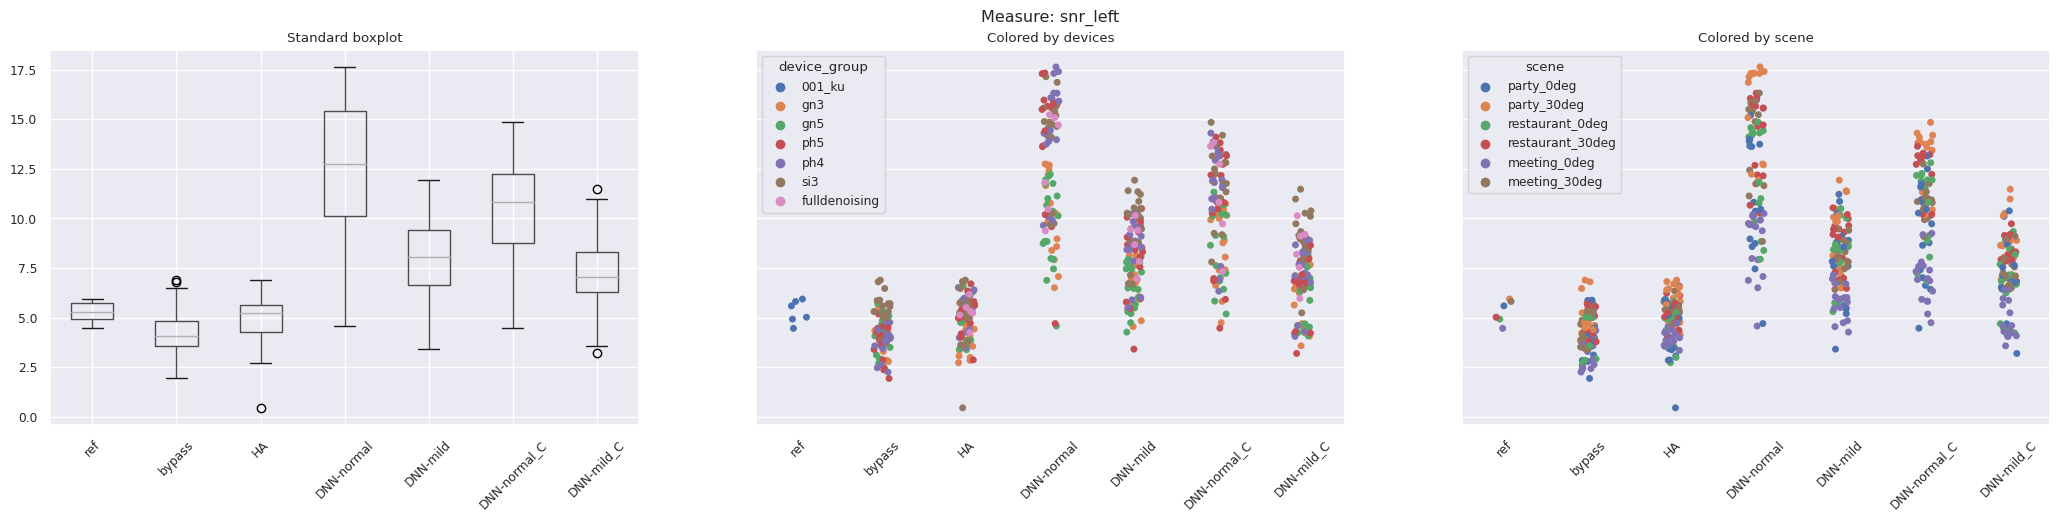

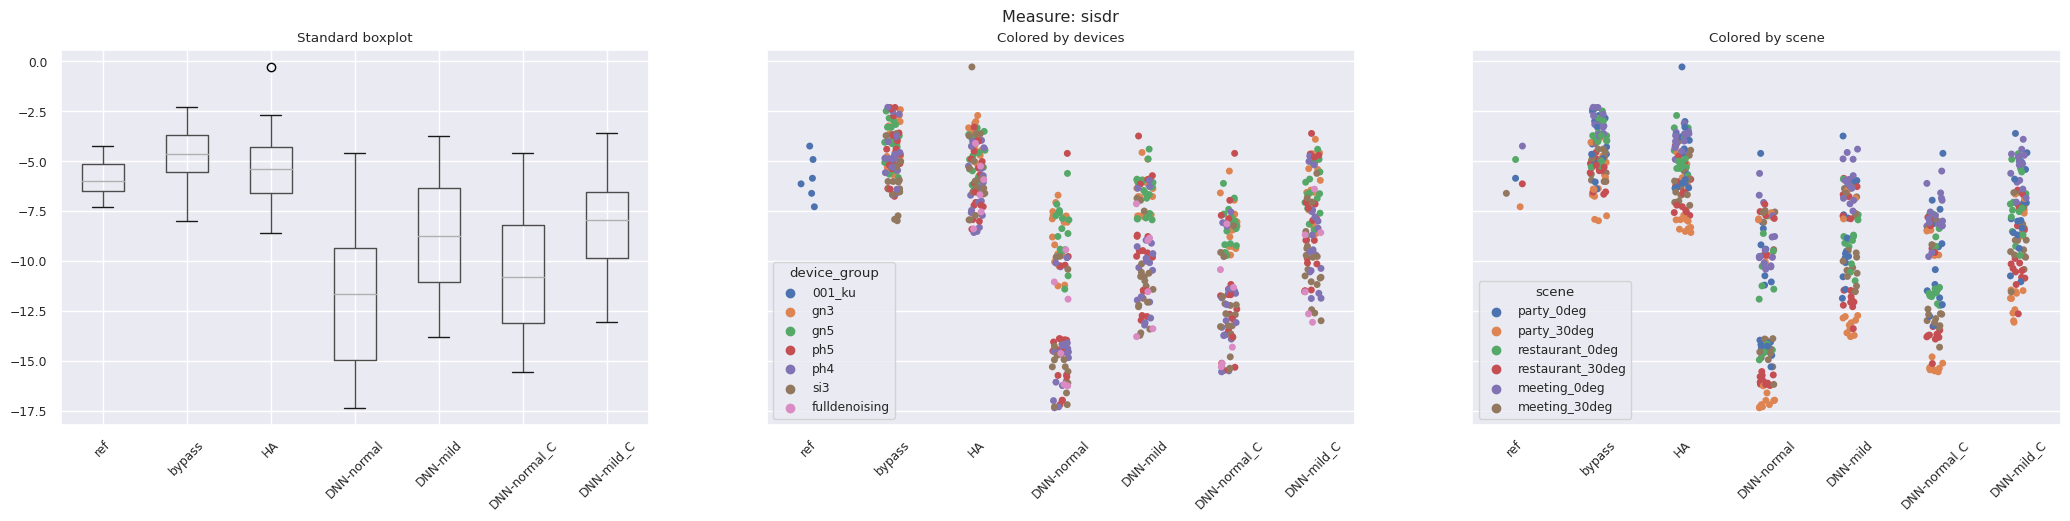

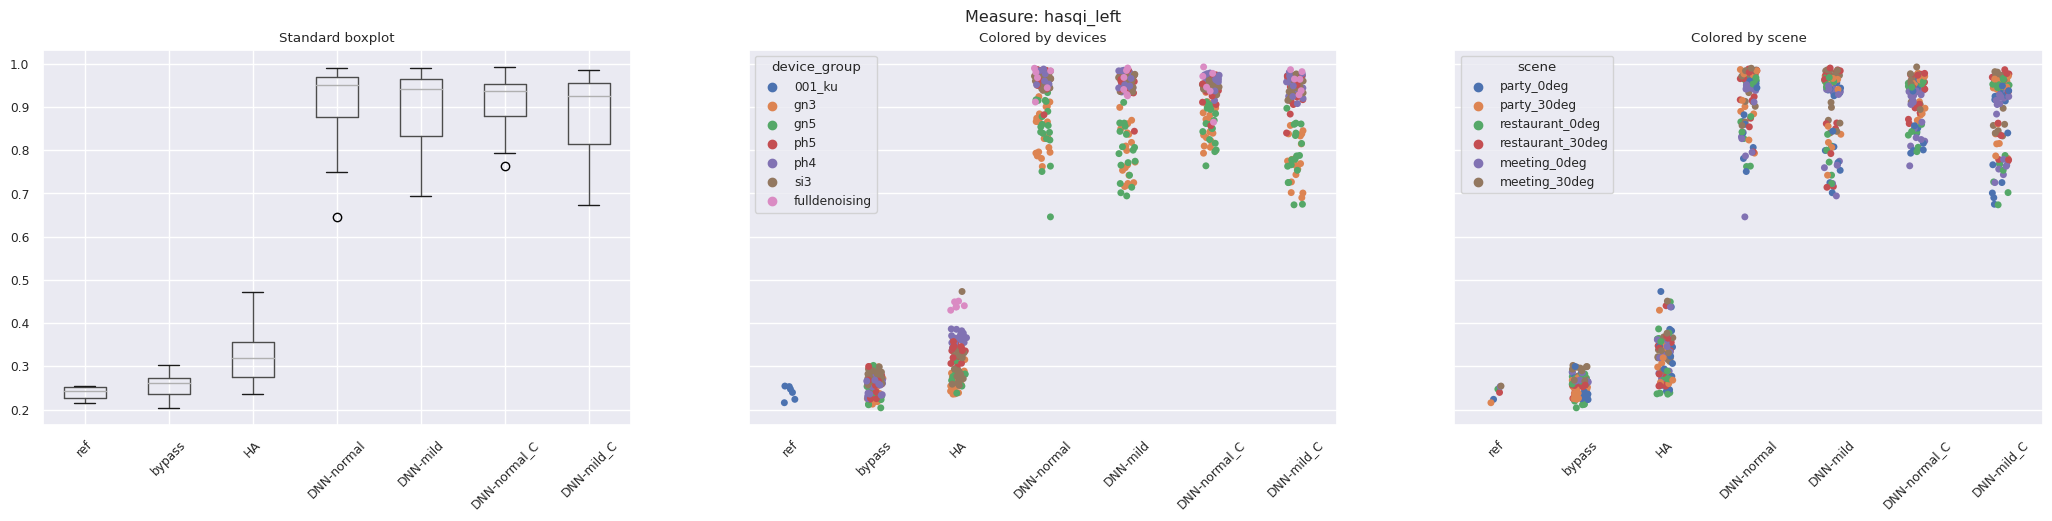

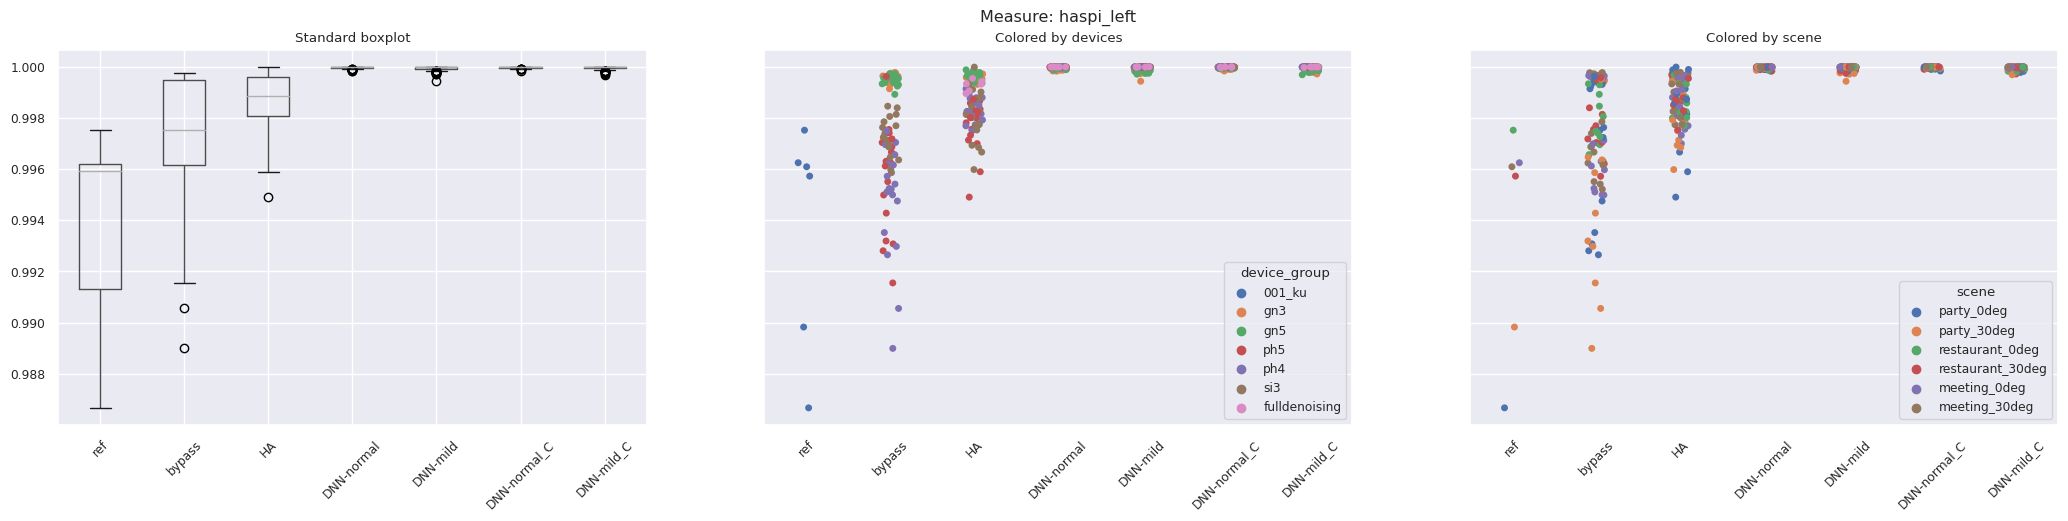

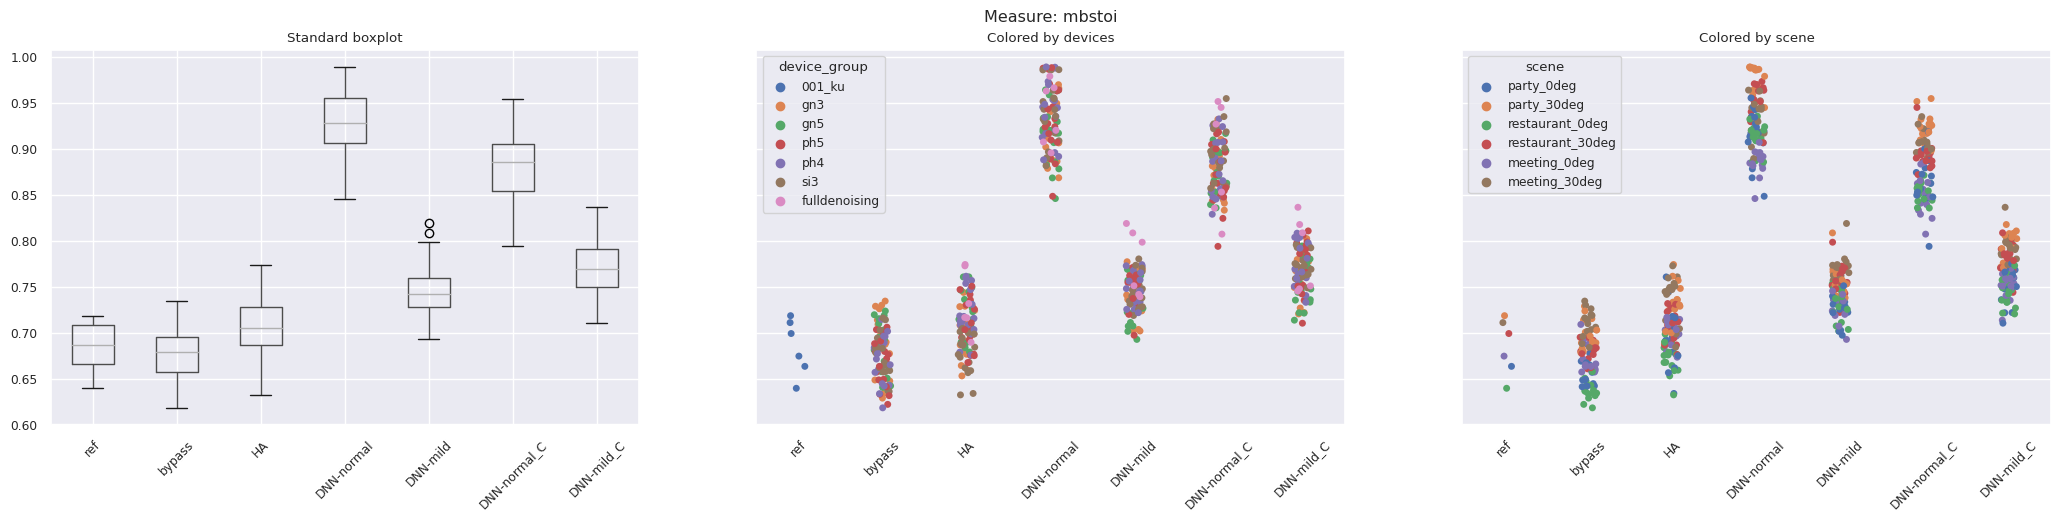

In [25]:
import seaborn as sns
import warnings
  
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

def plot_1_measure(df,measure):
    fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=True) 
    sns.set(font_scale=0.8)
    sns.stripplot(ax=axes[1],data=df,x="dnn_applied", y=measure, hue="device_group")
    sns.stripplot(ax=axes[2],data=df,x="dnn_applied", y=measure, hue="scene")
    df.boxplot(ax=axes[0],column=measure,by="dnn_applied")
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')
    axes[2].set_xlabel('')
    axes[0].set_title('Standard boxplot')
    axes[1].set_title('Colored by devices')
    axes[2].set_title('Colored by scene')
    axes[0].set_xticklabels(['ref','bypass','HA','DNN-normal','DNN-mild','DNN-normal_C','DNN-mild_C'], rotation=45)
    axes[1].set_xticklabels(['ref','bypass','HA','DNN-normal','DNN-mild','DNN-normal_C','DNN-mild_C'], rotation=45)
    axes[2].set_xticklabels(['ref','bypass','HA','DNN-normal','DNN-mild','DNN-normal_C','DNN-mild_C'], rotation=45)
    fig.suptitle('Measure: '+ measure)
    plt.show()

# Plot all measures:
plot_1_measure(measures_computed,"snr_left")
plot_1_measure(measures_computed,"sisdr")
plot_1_measure(measures_computed,"hasqi_left")
plot_1_measure(measures_computed,"haspi_left")
plot_1_measure(measures_computed,"mbstoi")


In [26]:
# Anova analysis...
import statsmodels.api as sm
from statsmodels.formula.api import ols

# perform three-way anova: how snr_left depends on 3 categorical variables (processing type, scene, and device group)
model = ols("""snr_left ~ C(dnn_applied) + C(scene) + C(device_group) +
               C(dnn_applied):C(scene) + C(dnn_applied):C(device_group) + C(scene):C(device_group) +
               C(dnn_applied):C(scene):C(device_group)""", data=measures_computed).fit()

sm.stats.anova_lm(model, typ=2)


# TODO: Why is the dnn_applied not significant??? 


,sum_sq,df,F,PR(>F)
C(dnn_applied),-8.385679e-11,6.0,-1.739034e-11,1.000000e+00
C(scene),8.702557e+02,5.0,2.165698e+02,3.570061e-106
C(device_group),-1.946002e-10,6.0,-4.035646e-11,1.000000e+00
C(dnn_applied):C(scene),6.680735e-13,30.0,2.770921e-14,1.000000e+00
C(dnn_applied):C(device_group),6.825126e+03,36.0,2.359007e+02,7.292134e-217
C(scene):C(device_group),-4.179145e-11,30.0,-1.733354e-12,1.000000e+00
C(dnn_applied):C(scene):C(device_group),4.036697e+02,180.0,2.790454e+00,1.249364e-16
Residual,2.893219e+02,360.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(has_dnn),1.477721e-10,1.0,3.111218e-11,9.999956e-01
C(scene),8.702556e+02,5.0,3.664500e+01,5.575418e-32
C(device_group),6.693344e+02,6.0,2.348712e+01,1.775799e-24
C(has_dnn):C(scene),-2.421868e-10,5.0,-1.019808e-11,1.000000e+00
C(has_dnn):C(device_group),3.149286e+03,6.0,1.105093e+02,2.980443e-88
C(scene):C(device_group),1.241558e+02,30.0,8.713323e-01,6.655807e-01
C(has_dnn):C(scene):C(device_group),1.514957e+02,30.0,1.063205e+00,3.779973e-01
Residual,2.365328e+03,498.0,NaN,NaN


In [31]:
9.999956e-01

0.9999956